# Helicentrism metric

* Bball reference USG%
* Cleaning the glass USG% (includes assist)
> Both uses only made FG and FT, not attempts

* https://www.thespax.com/nba/the-rise-of-heliocentrism-in-nba-offenses/#easy-footnote-2-4406
> FGA+0.44*FTA+AST+TOV. This methodology ignores offensive fouls and passes that don’t lead to assists, but it’s the best we can do with the historic data we have.

Not a big deal if we consider AST ~ pass that lead to assists. however, not the same factor : we should multiply by a constant ? Take average FG%, multiply AST by 1/FG%.

Other choice : on one game or per 36min ? Here I used per_game stats, just have to change this prefix.
Per game problem : skewed vers la droite car valable que pour les joueurs ayant joué. Le total de la moyenne par game des joueurs n'est psa la moyenne du total par game.

In [35]:
from nba_mvp_predictor.load import load_player_stats

In [36]:
stats = load_player_stats()
stats.sample(3)

,PLAYER,POS,AGE,TEAM,G,GS,MP,FG_per_game,FGA_per_game,FG%,...,TOV%_advanced,USG%_advanced,OWS_advanced,DWS_advanced,WS_advanced,WS/48_advanced,OBPM_advanced,DBPM_advanced,BPM_advanced,VORP_advanced
player_season_team,,,,,,,,,,,,,,,,,,,,,
JeffGreen_2020_HOU,JeffGreen,C,33,HOU,18,2,22.6,4.7,8.3,0.564,...,8.5,17.9,1.2,0.4,1.5,0.183,2.5,0.1,2.6,0.5
ChandlerParsons_2012_HOU,ChandlerParsons,SF,23,HOU,63,57,28.6,3.9,8.7,0.452,...,12.2,16.7,1.6,1.8,3.4,0.090,0.1,0.7,0.8,1.3
ZhouQi_2019_HOU,ZhouQi,PF,23,HOU,1,0,1.0,1.0,1.0,1.000,...,0.0,43.4,0.0,0.0,0.0,1.261,40.1,11.9,52.0,0.0


In [37]:
mean_fg_pct = stats['FG%'].mean()
print(mean_fg_pct)

0.4330748792270531


Alternative plus précise (et encore on pourrrait décliner par joueur, par zone...)

In [38]:
stats.groupby(['TEAM', 'SEASON']).mean()['FG%'].sample(5)

TEAM  SEASON
NJN   2011      0.420182
BOS   2017      0.472667
ORL   2016      0.422176
MEM   2006      0.478563
UTA   2016      0.413294
Name: FG%, dtype: float64

<AxesSubplot:title={'center':'Average FG%'}, xlabel='SEASON'>

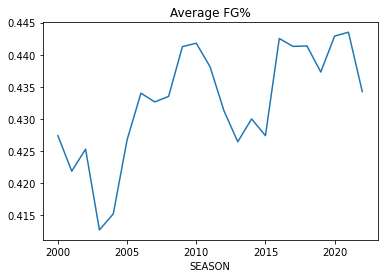

In [39]:
stats.groupby('SEASON').mean()['FG%'].plot(title="Average FG%")
# Attention, moyenne des joueurs, pas des tirs...

<AxesSubplot:ylabel='Frequency'>

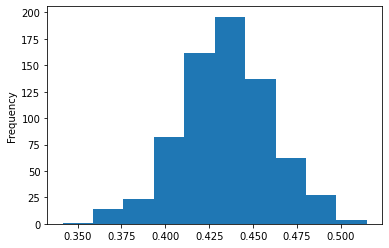

In [40]:
stats.groupby(['TEAM', 'SEASON']).mean()['FG%'].plot.hist()

In [41]:
stats = stats [[
    'TEAM', 'PLAYER', 'SEASON', 'FGA_per_game',
    'FTA_per_game', 'TOV_per_game', 'AST_per_game', 'USG%_advanced',
    'TOV%_advanced'
    ]]

In [42]:
stats.sample(3)

,TEAM,PLAYER,SEASON,FGA_per_game,FTA_per_game,TOV_per_game,AST_per_game,USG%_advanced,TOV%_advanced
player_season_team,,,,,,,,,
JRSmith_2010_DEN,DEN,JRSmith,2010,13.8,2.7,1.9,2.4,26.9,11.0
CassiusWinston_2022_WAS,WAS,CassiusWinston,2022,1.6,0.6,0.4,1.0,18.0,19.0
DarkoMiličić_2012_MIN,MIN,DarkoMiličić,2012,4.5,1.3,1.1,0.6,16.8,17.9


Des petits biais dus au fait que les games joués sont peut-être pas les mêmes entre différents joueurs. Peut-être faire le calcul sur chaque match, puis une moyenne sur la saison.

In [43]:
stats.loc[:, 'num_possessions_used_per_game'] = (
    stats['FGA_per_game'] 
    + 0.44*stats['FTA_per_game'] 
    + stats['TOV_per_game'] 
    + (stats['AST_per_game'] / mean_fg_pct) # va compter double du coup : pour le passeur et le shooteur
)
# + pass leading to FGA
# + pass leading to FTA
# instead of assists. Herewe estimate all passes leading to FGA using FG%. We should do the same for FTA, using FT% maybe ?
# Also add offensive fouls maybe ? but that is rare.

stats['num_possessions_used_per_game'].sort_values(ascending=False).head(5)

player_season_team
RussellWestbrook_2017_OKC    57.990323
JamesHarden_2017_HOU         55.257579
RussellWestbrook_2021_WAS    53.632113
RussellWestbrook_2018_OKC    52.807416
RussellWestbrook_2019_OKC    52.135044
Name: num_possessions_used_per_game, dtype: float64

fg% = fgm / fga
fgm = fga * fg%
fga = fgm / fg%
ast = fgm
ast leading to fgm = ast / fg%

In [44]:
team_totals = stats.groupby(['TEAM', 'SEASON'])[['num_possessions_used_per_game', 'USG%_advanced']].sum()
team_totals.sample(5)

num_possessions_used_per_game  USG%_advanced
TEAM SEASON                                              
GSW  2010                       333.107360          352.5
POR  2008                       173.325668          275.1
LAC  2009                       268.009084          364.3
     2000                       210.254342          316.5
TOR  2003                       244.811365          372.2

In [45]:
value = team_totals.loc["DET", 2020]["num_possessions_used_per_game"]
stats_with_totals = stats.join(team_totals, how="left", on=["TEAM", "SEASON"], rsuffix="_team_total")
stats_with_totals.sample(5)

,TEAM,PLAYER,SEASON,FGA_per_game,FTA_per_game,TOV_per_game,AST_per_game,USG%_advanced,TOV%_advanced,num_possessions_used_per_game,num_possessions_used_per_game_team_total,USG%_advanced_team_total
player_season_team,,,,,,,,,,,,
JoakimNoah_2017_NYK,NYK,JoakimNoah,2017,4.4,1.7,1.3,2.2,12.6,19.7,11.527953,213.707365,291.0
RobertCovington_2014_HOU,HOU,RobertCovington,2014,2.0,0.0,0.1,0.0,19.3,6.7,2.100000,226.394667,323.9
MettaWorldPeace_2000_CHI,CHI,MettaWorldPeace,2000,10.5,3.9,2.3,2.8,21.4,15.8,20.981395,297.210338,386.6
DarkoMiličić_2006_ORL,ORL,DarkoMiličić,2006,6.7,1.4,1.2,1.1,19.3,14.1,11.055976,229.369551,337.4
GustavoAyón_2013_TOT,TOT,GustavoAyón,2013,3.0,0.9,0.9,1.3,14.5,19.9,7.297790,470.238494,888.9


In [46]:
stats_with_totals.loc[:, "num_possessions_used_%"] = 100 * stats_with_totals["num_possessions_used_per_game"] / stats_with_totals["num_possessions_used_per_game_team_total"]
stats_with_totals.loc[:, "num_possessions_used_%"] = stats_with_totals["num_possessions_used_%"].round(decimals=1)
stats_with_totals.sample(5)

,TEAM,PLAYER,SEASON,FGA_per_game,FTA_per_game,TOV_per_game,AST_per_game,USG%_advanced,TOV%_advanced,num_possessions_used_per_game,num_possessions_used_per_game_team_total,USG%_advanced_team_total,num_possessions_used_%
player_season_team,,,,,,,,,,,,,
GalMekel_2014_DAL,DAL,GalMekel,2014,2.8,0.4,1.0,2.0,19.0,25.4,8.594139,189.338295,286.3,4.5
EricDawson_2012_SAS,SAS,EricDawson,2012,3.0,0.5,0.8,0.0,18.6,18.9,4.020000,247.550851,384.6,1.6
BrandonRush_2010_IND,IND,BrandonRush,2010,8.6,1.1,1.1,1.4,14.8,11.1,13.416697,212.767016,285.0,6.3
JJRedick_2019_PHI,PHI,JJRedick,2019,13.5,3.4,1.3,2.7,21.9,8.1,22.530488,360.787615,465.1,6.2
KendrickPerkins_2011_TOT,TOT,KendrickPerkins,2011,4.5,2.5,1.9,0.9,13.7,25.7,9.578163,992.946057,1498.8,1.0


In [47]:
stats_with_totals[['num_possessions_used_%', 'USG%_advanced']].sort_values(by ='num_possessions_used_%', ascending=False).head(20)

,num_possessions_used_%,USG%_advanced
player_season_team,,
AllenIverson_2006_PHI,27.4,35.8
RussellWestbrook_2018_OKC,27.0,34.1
ChrisPaul_2009_NOH,26.2,27.5
RussellWestbrook_2017_OKC,25.3,41.7
ChrisPaul_2008_NOH,25.2,25.7
RussellWestbrook_2019_OKC,24.7,30.9
LeBronJames_2009_CLE,24.7,33.8
RussellWestbrook_2016_OKC,24.5,31.6
KobeBryant_2006_LAL,24.5,38.7


<AxesSubplot:xlabel='USG%_advanced'>

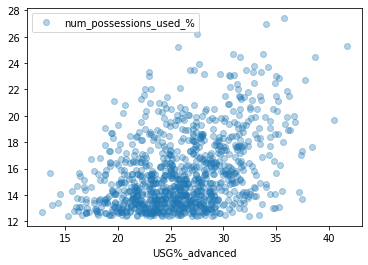

In [48]:
stats_with_totals[['num_possessions_used_%', 'USG%_advanced']].sort_values(by ='num_possessions_used_%', ascending=False).head(1000).plot(x='USG%_advanced', y='num_possessions_used_%', style='o', alpha=0.33)

In [49]:
from matplotlib import pyplot

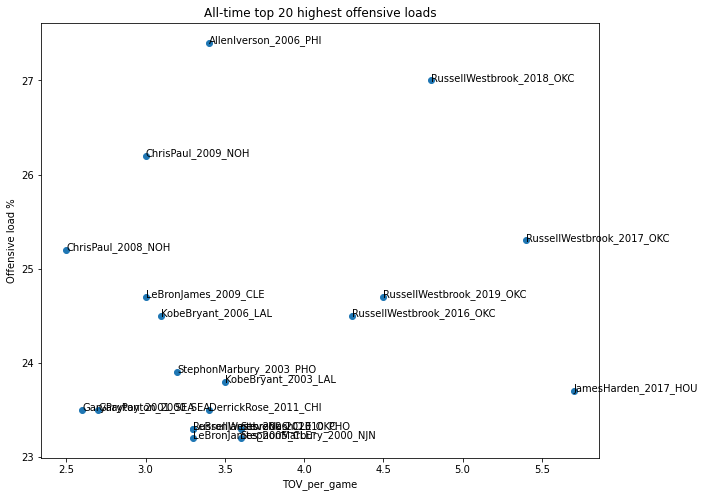

In [50]:
fig, ax = pyplot.subplots()

num_players = 20

dataframe = stats_with_totals[['num_possessions_used_%', 'TOV_per_game']].sort_values(by ='num_possessions_used_%', ascending=False).head(num_players)
dataframe.plot(x='TOV_per_game', y='num_possessions_used_%', style='o', alpha=1., ylabel="Offensive load %", title=f"All-time top {num_players} highest offensive loads", legend=False, figsize=(10, 8), ax=ax)

for i, txt in enumerate(dataframe.index):
    ax.annotate(txt, (dataframe['TOV_per_game'].to_list()[i], dataframe['num_possessions_used_%'].to_list()[i]))

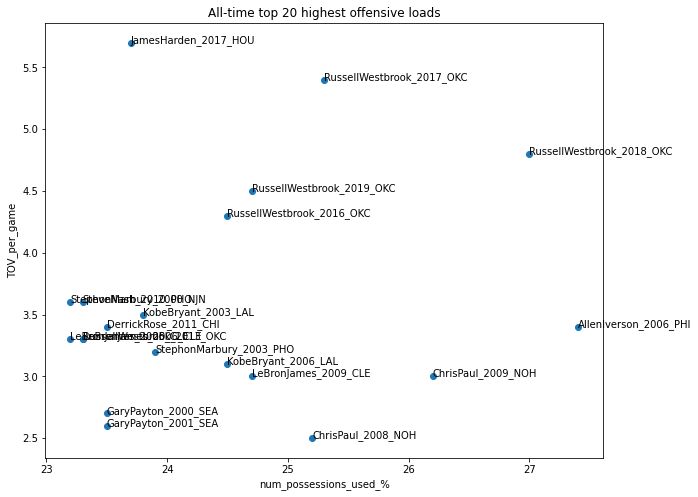

In [51]:
fig, ax = pyplot.subplots()

num_players = 20

dataframe = stats_with_totals[['num_possessions_used_%', 'TOV_per_game']].sort_values(by ='num_possessions_used_%', ascending=False).head(num_players)
dataframe.plot(x='num_possessions_used_%', y='TOV_per_game', style='o', alpha=1., ylabel="TOV_per_game", title=f"All-time top {num_players} highest offensive loads", legend=False, figsize=(10, 8), ax=ax)

for i, txt in enumerate(dataframe.index):
    ax.annotate(txt, (dataframe['num_possessions_used_%'].to_list()[i], dataframe['TOV_per_game'].to_list()[i]))

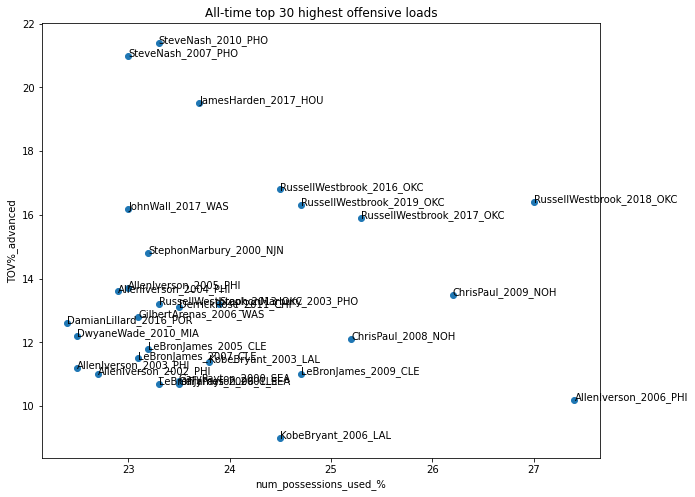

In [54]:
fig, ax = pyplot.subplots()

num_players = 30

dataframe = stats_with_totals[['num_possessions_used_%', 'TOV%_advanced']].sort_values(by ='num_possessions_used_%', ascending=False).head(num_players)
dataframe.plot(x='num_possessions_used_%', y='TOV%_advanced', style='o', alpha=1., ylabel="TOV%_advanced", title=f"All-time top {num_players} highest offensive loads", legend=False, figsize=(10, 8), ax=ax)

for i, txt in enumerate(dataframe.index):
    ax.annotate(txt, (dataframe['num_possessions_used_%'].to_list()[i], dataframe['TOV%_advanced'].to_list()[i]))

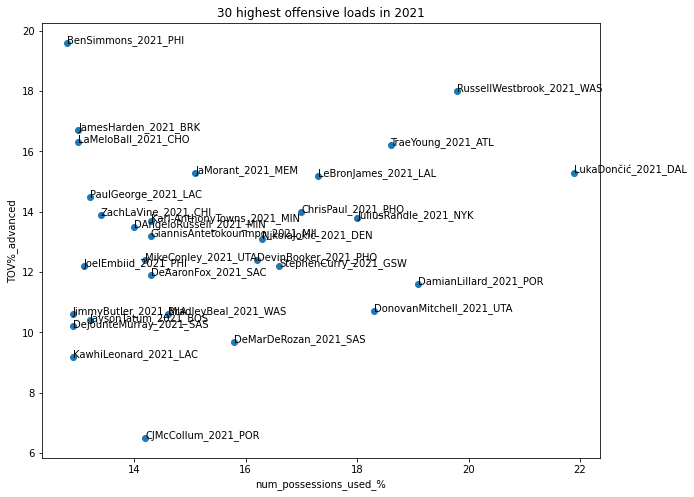

In [60]:
fig, ax = pyplot.subplots()

num_players = 30
season = 2021

dataframe = stats_with_totals[stats_with_totals["SEASON"]==season][['num_possessions_used_%', 'TOV%_advanced']].sort_values(by ='num_possessions_used_%', ascending=False).head(num_players)
dataframe.plot(x='num_possessions_used_%', y='TOV%_advanced', style='o', alpha=1., ylabel="TOV%_advanced", title=f"{num_players} highest offensive loads in {season}", legend=False, figsize=(10, 8), ax=ax)

for i, txt in enumerate(dataframe.index):
    ax.annotate(txt, (dataframe['num_possessions_used_%'].to_list()[i], dataframe['TOV%_advanced'].to_list()[i]))

In [53]:
stats['USG%_advanced'].sort_values(ascending=False).head(20)

player_season_team
ParisBass_2022_PHO              54.6
JackieButler_2005_NYK           53.7
DeAndreLiggins_2014_MIA         47.8
TerrenceJones_2019_HOU          47.2
MileIlić_2007_NJN               46.6
VonWafer_2007_LAC               46.2
JamesSoutherland_2014_CHA       46.2
ToureMurry_2015_UTA             45.8
ShannonBrown_2008_CHI           45.5
LarryRobinson_2001_CLE          45.2
ChrisJefferies_2004_TOR         45.1
NazMitrou-Long_2018_UTA         45.0
Nenê_2006_DEN                   44.8
MarioBennett_2000_LAC           44.4
MattWalsh_2006_MIA              44.3
MattRyan_2022_BOS               44.0
JustinWilliams_2008_HOU         43.9
ChrisBoucher_2018_GSW           43.9
MattMooney_2022_NYK             43.8
MindaugasKuzminskas_2018_NYK    43.7
Name: USG%_advanced, dtype: float64

Reading : in 2021 Doncic created 21.9% of all shots attempted by the Mavericks.
> Should we remove offensive fouls and turnover ? Because this sentence is not exact.
> Also hockey pass not count... not great because a player might attract defense and free up shooters.
> And does not sum to 1

On pourait avoir : FGA=1, AST=0.5, hockey assist=0.25
Mettre au regard de la durée moyenne vaec blale dans les mains, années, titre, playoffs, ranking.. 